In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
from math import sin as sine
sin=np.vectorize(sine)
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run2_IFG_timescan.root")
hist_tmp = ROOT.TH1D()
hist_tmp = file.Get("hcalo_ratio_1")

In [3]:
fit_start=30000
fit_stop=305000
fit_range=hist_tmp.FindBin(fit_stop)-hist_tmp.FindBin(fit_start)+1
y_val=np.empty(shape=(40,fit_range))
y_err=np.empty(shape=(40,fit_range))
x_val=np.empty(shape=(40,fit_range))
y_cov=np.empty(shape=(40,fit_range,fit_range))  

In [4]:
%%time
for icalo in range(0,40):
    hist = ROOT.TH1D()
    hcov = ROOT.TH2D()
    hist = file.Get("hcalo_ratio_"+str(icalo+1))
    for ibin in range (0,fit_range):
        y_val[icalo][ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
        y_err[icalo][ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
        x_val[icalo][ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
        
    hcov = file.Get("hcov_"+str(icalo+1))
    for irow in range (0, fit_range):
        for icol in range(0, fit_range):
            y_cov[icalo][irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))
            
    hist.Reset()
    hcov.Reset()

CPU times: user 4min 57s, sys: 1min 4s, total: 6min 1s
Wall time: 6min 1s


In [5]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [6]:
T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

asym=np.empty(40)
dasym=np.empty(40)
rval=np.empty(40)
drval=np.empty(40)
phi=np.empty(40)
dphi=np.empty(40)
A_cbo=np.empty(40)
dA_cbo=np.empty(40)
tau_cbo=np.empty(40)
dtau_cbo=np.empty(40)
omega_cbo=np.empty(40)
domega_cbo=np.empty(40)
phi_cbo=np.empty(40)
dphi_cbo=np.empty(40)
A_cbo_A=np.empty(40)
dA_cbo_A=np.empty(40)
phi_cbo_A=np.empty(40)
dphi_cbo_A=np.empty(40)
A_cbo_phi=np.empty(40)
dA_cbo_phi=np.empty(40)
phi_cbo_phi=np.empty(40)
dphi_cbo_phi=np.empty(40)
A_vw=np.empty(40)
dA_vw=np.empty(40)
tau_vw=np.empty(40)
dtau_vw=np.empty(40)
omega_vw=np.empty(40)
domega_vw=np.empty(40)
phi_vw=np.empty(40)
dphi_vw=np.empty(40)
A_y=np.empty(40)
dA_y=np.empty(40)
tau_y=np.empty(40)
dtau_y=np.empty(40)
omega_y=np.empty(40)
domega_y=np.empty(40)
phi_y=np.empty(40)
dphi_y=np.empty(40)
A_2cbo=np.empty(40)
dA_2cbo=np.empty(40)
tau_2cbo=np.empty(40)
dtau_2cbo=np.empty(40)
omega_2cbo=np.empty(40)
domega_2cbo=np.empty(40)
phi_2cbo=np.empty(40)
dphi_2cbo=np.empty(40)
A_new=np.empty(40)
dA_new=np.empty(40)
phi_new=np.empty(40)
dphi_new=np.empty(40)
A_cbo_t=np.empty(40)
dA_cbo_t=np.empty(40)
tau_cbo_t=np.empty(40)
dtau_cbo_t=np.empty(40)
tau_rlx=np.empty(40)
dtau_rlx=np.empty(40)
A_cbovw=np.empty(40)
dA_cbovw=np.empty(40)
phi_cbovw=np.empty(40)
dphi_cbovw=np.empty(40)
red_chi2=np.empty(40)
calonum=np.empty(40)


In [7]:
def fit_func3(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0)-> np.double:
    
    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f - ff - fb)/(2*f + ff + fb) 

In [8]:
def fit_func7(time: np.double,
              asym: np.double = 0.0, 
              R: np.double = 0.0, 
              phi: np.double = 0.0,
              asym_cbo = 0.0,
              tau_cbo = 0.0,
              omega_cbo = 0.0,
              phi_cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))

    f=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*time - phi))

    ff=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi))

    fb=(1+ asym*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [9]:
def fit_func11(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))


    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [10]:
def fit_func15(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0)-> np.double:
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))

    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo - ff*Ncbof - fb*Ncbob)/(2*f*Ncbo + ff*Ncbof + fb*Ncbob)

In [11]:
def fit_func19(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0)-> np.double:
    
    #tau_vw = 94208
    #omega_vw = 0.01392

    tau_vw=175334
    omega_vw=0.01393
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw - ff*Ncbof*Nvwf - fb*Ncbob*Nvwb)/(2*f*Ncbo*Nvw + ff*Ncbof*Nvwf + fb*Ncbob*Nvwb)

In [12]:
def fit_func23(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0)-> np.double:
    
    #tau_vw = 94208
    #omega_vw = 0.01392
    
    #tau_vbo = 25630
    #omega_vbo = 0.01402
    
    tau_vw=175334
    omega_vw=0.01393
    
    tau_vbo=28138
    omega_vbo=0.014037

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))


    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [13]:
def fit_func24(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0,
               A_cbot = 0.0)-> np.double:
    
    #tau_vw = 94208
    #omega_vw = 0.01392
    
    #tau_vbo = 25630
    #omega_vbo = 0.01402
    
    tau_vw=175334
    omega_vw=0.01393
    
    tau_vbo=28138
    omega_vbo=0.014037
    
    #tau_cbot= 64000
    tau_cbot= 19904
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))


    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [14]:
def fit_func25(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0,
               A_cbot = 0.0,
               tau_rlx = 0.0)-> np.double:
    
    #tau_vw = 94208
    #omega_vw = 0.01392
    
    #tau_vbo = 25630
    #omega_vbo = 0.01402
    
    tau_vw=175334
    omega_vw=0.01393
    
    tau_vbo=28138
    omega_vbo=0.014037
    
    #tau_cbot= 64000
    tau_cbot= 19904
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))

    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    N2cbo=(asym_2cbo*exp(-time/(tau_cbo/2))*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-(time + T_a/2)/(tau_cbo/2))*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-(time - T_a/2)/(tau_cbo/2))*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
       
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo - ff*Ncbof*Nvwf*Nvbof - fb*Ncbob*Nvwb*Nvbob)/(2*f*Ncbo*Nvw*Nvbo + ff*Ncbof*Nvwf*Nvbof + fb*Ncbob*Nvwb*Nvbob)

In [15]:
def fit_func28(time: np.double,
               asym: np.double = 0.0, 
               R: np.double = 0.0, 
               phi: np.double = 0.0,
               asym_cbo = 0.0,
               tau_cbo = 0.0,
               omega_cbo = 0.0,
               phi_cbo = 0.0,
               asym_cbo_A = 0.0,
               phi_cbo_A=0.0,
               A_cbo_phi= 0.0,
               phi_cbo_phi=0.0,
               asym_vw= 0.0,
               phi_vw = 0.0,
               asym_vbo= 0.0,
               phi_vbo = 0.0,
               asym_2cbo= 0.0,
               phi_2cbo = 0.0,
               A_cbot = 0.0,
               tau_rlx = 0.0,
               A_cbovw = 0.0,
               phi_cbovw = 0.0)-> np.double:
    
    tau_vw=175334
    omega_vw=0.01393
    
    tau_vbo=28138
    omega_vbo=0.014037
    
    #tau_cbot= 64000
    tau_cbot= 19904
        
    tau_cbovw = 51430
    omega_cbovw = 0.01197
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [16]:
p_init3=[2.28839e-01,
        0.000000,
        4.02055e+00]

In [17]:
%%time
for icalo in range(0,40): 
    pars3, cov3 = opt.curve_fit(f=fit_func3, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init3, sigma=y_err[icalo]) 
    
    p_init7=[pars3[0],
             pars3[1],
             pars3[2],
             0.02,
             240000,
             0.0023404,
             2.00+(icalo*(6.28/24))]
    
    pars7, cov7 = opt.curve_fit(f=fit_func7, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init7, sigma=y_err[icalo])
    
    p_init11=[pars7[0],
              pars7[1],
              pars7[2],
              pars7[3],
              pars7[4],
              pars7[5],
              pars7[6],
              0.02,
              1.1,
              0.003,
              1.2]
    
    pars11, cov11 = opt.curve_fit(f=fit_func11, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init11, sigma=y_err[icalo])
    
    p_init15=[pars11[0],
              pars11[1],
              pars11[2],
              pars11[3],
              pars11[4],
              pars11[5],
              pars11[6],
              pars11[7],
              pars11[8],
              pars11[9],
              pars11[10],
              0.001,
              5.1]
    
    pars15, cov15 = opt.curve_fit(f=fit_func15, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init15, sigma=y_err[icalo])

    p_init19=[pars15[0],
              pars15[1],
              pars15[2],
              pars15[3],
              pars15[4],
              pars15[5],
              pars15[6],
              pars15[7],
              pars15[8],
              pars15[9],
              pars15[10],
              pars15[11],
              pars15[12],
              0.0005,
              3.5]
    
    pars19, cov19 = opt.curve_fit(f=fit_func19, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init19, sigma=y_err[icalo])

    p_init23=[pars19[0],
              pars19[1],
              pars19[2],
              pars19[3],
              pars19[4],
              pars19[5],
              pars19[6],
              pars19[7],
              pars19[8],
              pars19[9],
              pars19[10],
              pars19[11],
              pars19[12],
              pars19[13],
              pars19[14],
              0.001,
              4.2]
    
    pars23, cov23 = opt.curve_fit(f=fit_func23, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init23, sigma=y_err[icalo])

    p_init24=[pars23[0],
              pars23[1],
              pars23[2],
              pars23[3],
              pars23[4],
              pars23[5],
              pars23[6],
              pars23[7],
              pars23[8],
              pars23[9],
              pars23[10],
              pars23[11],
              pars23[12],
              pars23[13],
              pars23[14],
              pars23[15],
              pars23[16],
              #-0.002
              0.006]
              #16400]
    
    pars24, cov24 = opt.curve_fit(f=fit_func24, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init24, sigma=y_err[icalo])
     
    #p_init25=[pars24[0],
              #pars24[1],
              #pars24[2],
              #pars24[3],
              #pars24[4],
              #pars24[5],
              #pars24[6],
              #pars24[7],
              #pars24[8],
              #pars24[9],
              #pars24[10],
              #pars24[11],
              #pars24[12],
              #pars24[13],
              #pars24[14],
              #pars24[15],
              #pars24[16],
              #pars24[17],
              #2.955e+08]
              
    
    #pars25, cov25 = opt.curve_fit(f=fit_func25, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init25, sigma=y_err[icalo])

    #p_init28=[pars25[0],
              #pars25[1],
              #pars25[2],
              #pars25[3],
              #pars25[4],
              #pars25[5],
              #pars25[6],
              #pars25[7],
              #pars25[8],
              #pars25[9],
              #pars25[10],
              #pars25[11],
              #pars25[12],
              #pars25[13],
              #pars25[14],
              #pars25[15],
              #pars25[16],
              #pars25[17],
              #pars25[18],
              #0.0001,
              #4.2]
    
    #pars28, cov28 = opt.curve_fit(f=fit_func28, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init28, sigma=y_err[icalo])

    p_init_final=pars24

    
    pars2, cov_final = opt.curve_fit(f=fit_func24, xdata=x_val[icalo], ydata=y_val[icalo], p0=p_init_final, sigma=y_cov[icalo])
    
    stdevs=np.sqrt(np.diag(cov_final))
    
    chi2=np.dot((np.transpose(y_val[icalo]-fit_func24(x_val[icalo], *pars2))),(np.dot((np.linalg.inv(y_cov[icalo])),(y_val[icalo]-fit_func24(x_val[icalo], *pars2)))))
    red_chi2[icalo]=chi2/(fit_range-len(pars2))
    
    calonum[icalo]=(icalo*0.05)+0.05
    
    asym[icalo]=pars2[0]
    dasym[icalo]=stdevs[0]
    rval[icalo]=pars2[1]
    drval[icalo]=stdevs[1]
    phi[icalo]=pars2[2]
    dphi[icalo]=stdevs[2]
    A_cbo[icalo]=pars2[3]
    dA_cbo[icalo]=stdevs[3]
    tau_cbo[icalo]=pars2[4]
    dtau_cbo[icalo]=stdevs[4]
    omega_cbo[icalo]=pars2[5]
    domega_cbo[icalo]=stdevs[5]
    phi_cbo[icalo]=pars2[6]
    dphi_cbo[icalo]=stdevs[6]
    A_cbo_A[icalo]=pars2[7]
    dA_cbo_A[icalo]=stdevs[7]
    phi_cbo_A[icalo]=pars2[8]
    dphi_cbo_A[icalo]=stdevs[8]
    A_cbo_phi[icalo]=pars2[9]
    dA_cbo_phi[icalo]=stdevs[9]
    phi_cbo_phi[icalo]=pars2[10]
    dphi_cbo_phi[icalo]=stdevs[10]
    A_2cbo[icalo]=pars2[11]
    dA_2cbo[icalo]=stdevs[11]
    phi_2cbo[icalo]=pars2[12]
    dphi_2cbo[icalo]=stdevs[12]
    A_y[icalo]=pars2[13]
    dA_y[icalo]=stdevs[13]
    phi_y[icalo]=pars2[14]
    dphi_y[icalo]=stdevs[14]
    A_vw[icalo]=pars2[15]
    dA_vw[icalo]=stdevs[15]
    phi_vw[icalo]=pars2[16]
    dphi_vw[icalo]=stdevs[16]
    A_cbo_t[icalo]=pars2[17]
    dA_cbo_t[icalo]=stdevs[17]
    #tau_rlx[icalo]=pars2[18]
    #dtau_rlx[icalo]=stdevs[18]
    #A_cbovw[icalo]=pars2[19]
    #dA_cbovw[icalo]=stdevs[19]
    #phi_cbovw[icalo]=pars2[20]
    #dphi_cbovw[icalo]=stdevs[20]    
    


CPU times: user 5min 35s, sys: 1min 17s, total: 6min 52s
Wall time: 3min 44s


In [18]:
red_chi2

array([0.96737943, 0.96737933, 0.96737936, 0.96737927, 0.96737791,
       0.96736454, 0.96730887, 0.96715591, 0.96684037, 0.96631063,
       0.96554718, 0.96456973, 0.96343491, 0.96222336, 0.96102587,
       0.95993051, 0.95901354, 0.95833118, 0.95792295, 0.95780683,
       0.95798463, 0.95844428, 0.95916333, 0.9601125 , 0.96125816,
       0.96256506, 0.96399791, 0.96552285, 0.96710837, 0.96872601,
       0.97035033, 0.97195964, 0.97353512, 0.9750616 , 0.97652654,
       0.97791989, 0.97923455, 0.98046511, 0.9816083 , 0.98266174])

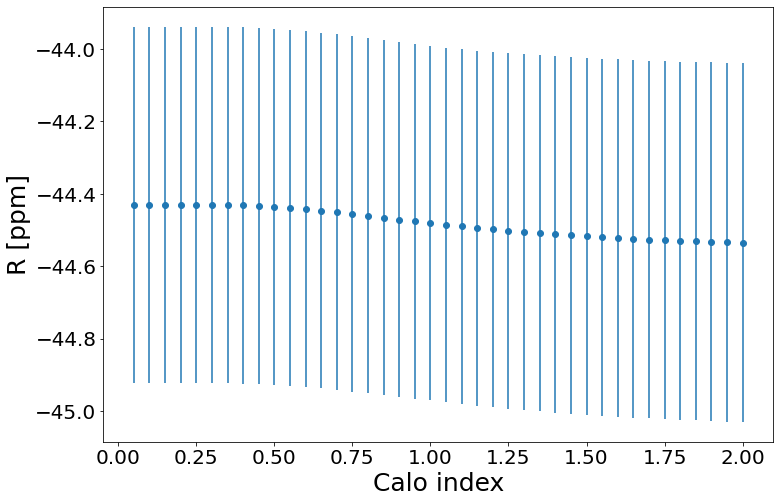

In [19]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval, fmt="o")
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
#plt.savefig('run2_caloscan_R.jpg')

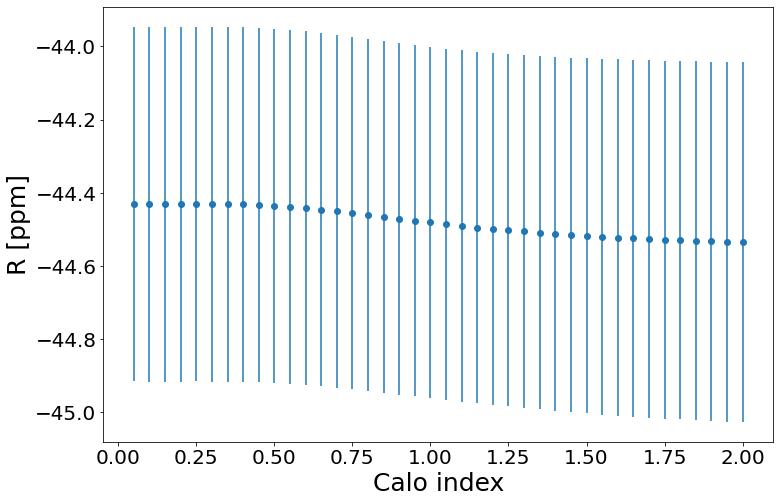

In [20]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval*np.sqrt(red_chi2), fmt="o")
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()

In [21]:
def fit_Rwave(x: np.double,
              amp: np.double = 0.0, 
              phase: np.double = 0.0, 
              offset: np.double = 0.0)-> np.double:
    
    Romega=0.2618
    
    return amp*sin(Romega*x+phase)+offset

p_0=[1.0,1.5,-45]

rwave_p, rwave_cov = opt.curve_fit(f=fit_Rwave, xdata=calonum, ydata=rval, p0=p_0, sigma=drval*np.sqrt(red_chi2))

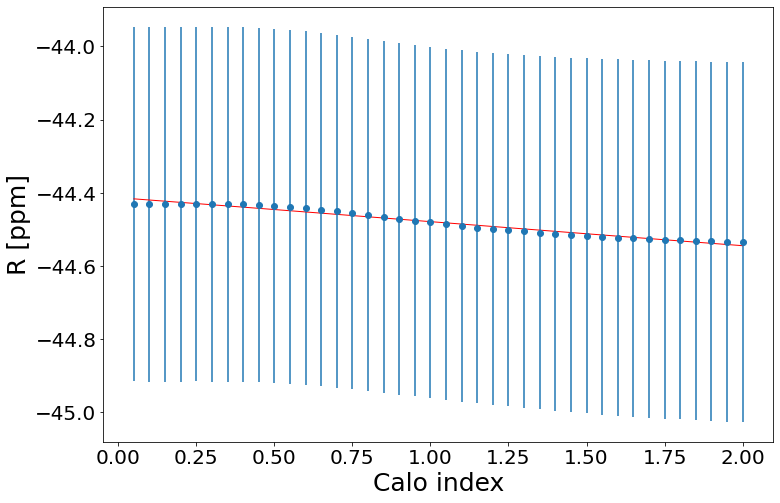

chi2/ndf= 0.007614428180179529 /21
amplitude= -0.25336968585159786  phase= 6.007055204656926  offset= -44.48247110264096


In [22]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval*np.sqrt(red_chi2), fmt="o")
plt.plot(calonum, fit_Rwave(calonum, *rwave_p), linestyle='solid', linewidth=1, color='red')
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
chi2_1=np.empty(24)
chi2_1=(fit_Rwave(calonum, *rwave_p)-rval)*(fit_Rwave(calonum, *rwave_p)-rval)/(drval*drval*np.sqrt(red_chi2)*np.sqrt(red_chi2))
print('chi2/ndf=',sum(chi2_1),'/21')
print('amplitude=',rwave_p[0],' phase=',rwave_p[1],' offset=',rwave_p[2])
#plt.savefig('run2_caloscan_Rfit_sine.jpg')

In [23]:
def fit_straight(x: np.double, 
                 slope: np.double = 0.0,
                 offset: np.double = 0.0)-> np.double:
    
    return offset+slope*x

p2_0=[-45,1]

rwave2_p, rwave2_cov = opt.curve_fit(f=fit_straight, xdata=calonum, ydata=rval, p0=p2_0, sigma=drval*np.sqrt(red_chi2))

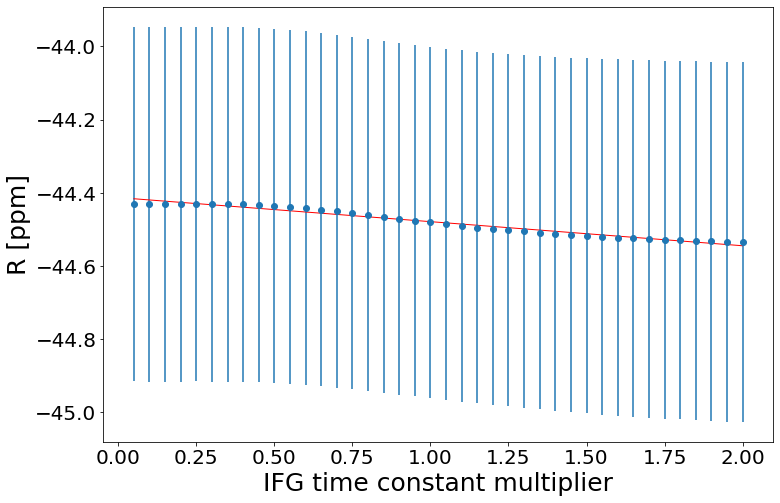

chi2/ndf= 0.007861255965814504 /23
offset= -0.06584531164092337
slope= -44.41302945728427


In [24]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval, yerr=drval*np.sqrt(red_chi2), fmt="o")
plt.plot(calonum, fit_straight(calonum, *rwave2_p), linestyle='solid', linewidth=1, color='red')
plt.xlabel("IFG time constant multiplier",fontsize=25)
plt.ylabel('R [ppm]',fontsize=25)
plt.show()
chi2_2=np.empty(24)
chi2_2=(fit_straight(calonum, *rwave2_p)-rval)*(fit_straight(calonum, *rwave2_p)-rval)/(drval*drval*np.sqrt(red_chi2)*np.sqrt(red_chi2))
print('chi2/ndf=',sum(chi2_2),'/23')
print('offset=',rwave2_p[0])
print('slope=',rwave2_p[1])
#plt.savefig('run2_caloscan_Rfit_straight.jpg')

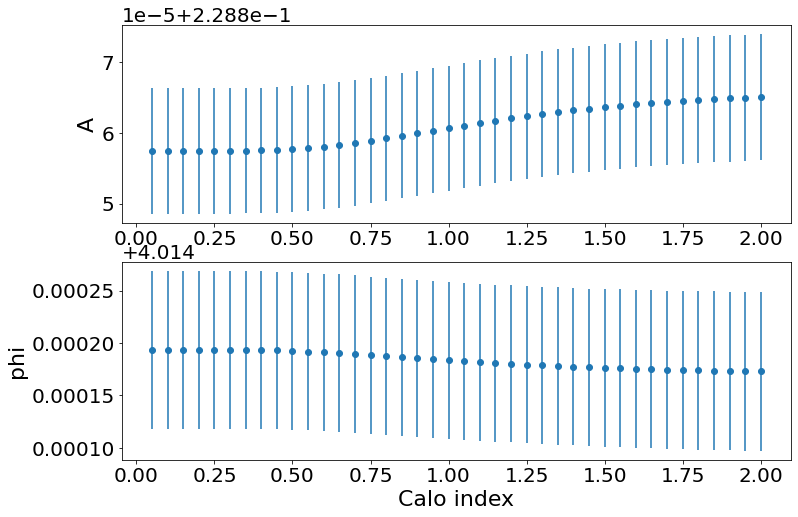

In [25]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, asym, yerr=dasym, fmt="o")
plt.ylabel('A',fontsize=22)
 
# second line
plt.subplot(212)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, phi, yerr=dphi, fmt="o")
plt.xlabel('Calo index',fontsize=22)
plt.ylabel('phi',fontsize=22)

plt.show()
#plt.savefig('run2_caloscan_A_phi.jpg')

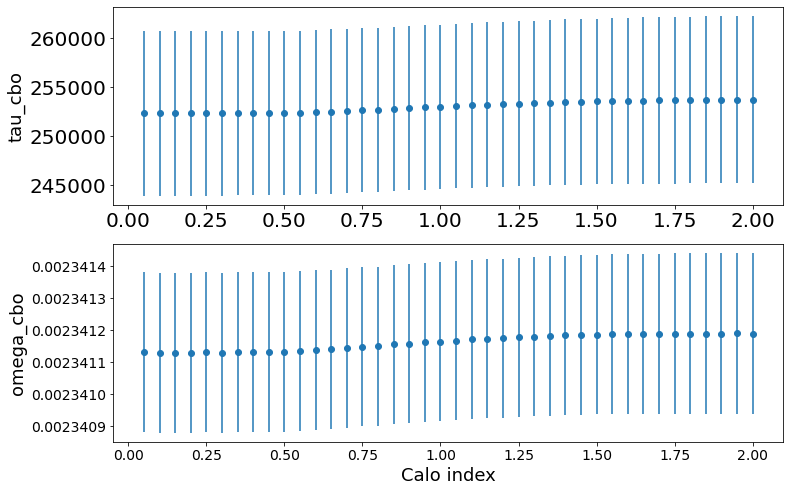

In [26]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, tau_cbo, yerr=dtau_cbo, fmt="o")
plt.ylabel('tau_cbo',fontsize=18)
 
# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, omega_cbo, yerr=domega_cbo, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('omega_cbo',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_tau_omega_cbo.jpg')

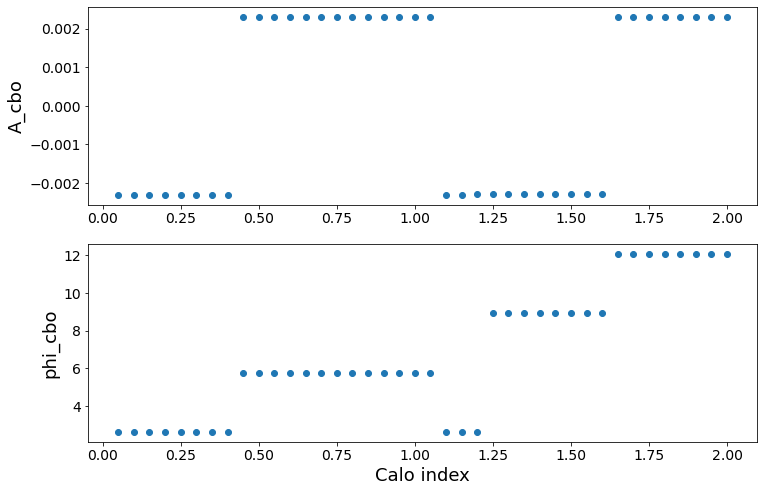

In [27]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, A_cbo, yerr=dA_cbo, fmt="o")
plt.ylabel('A_cbo',fontsize=18)

for icalo in range(0,24):
    if phi_cbo[icalo]>6.28:
        phi_cbo[icalo]=phi_cbo[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_cbo, yerr=dphi_cbo, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_cbo',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_cbo.jpg')

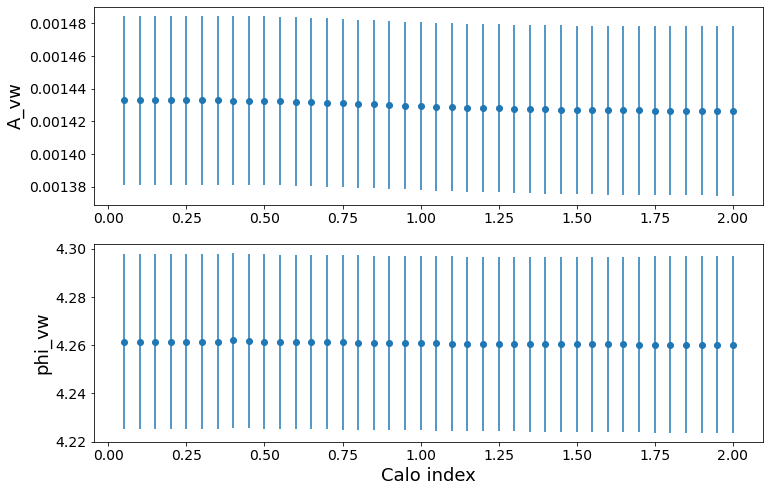

In [28]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, np.abs(A_vw), yerr=dA_vw, fmt="o")
plt.ylabel('A_vw',fontsize=18)

for icalo in range(0,24):
    if phi_vw[icalo]>6.28:
        phi_vw[icalo]=phi_vw[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_vw, yerr=dphi_vw, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_vw',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_vw.jpg')

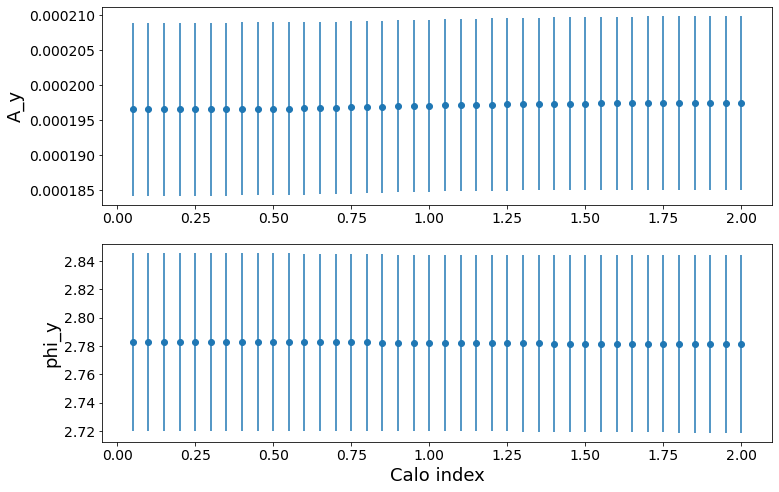

In [29]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, np.abs(A_y), yerr=dA_y, fmt="o")
plt.ylabel('A_y',fontsize=18)

for icalo in range(0,24):
    if phi_y[icalo]>6.28:
        phi_y[icalo]=phi_y[icalo]-6.28

# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, phi_y, yerr=dphi_y, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_y',fontsize=18)

plt.show()
#plt.savefig('run2_caloscan_A_phi_y.jpg')

In [30]:
rval

array([-44.43082658, -44.43105113, -44.4312268 , -44.43102822,
       -44.43078272, -44.43119082, -44.43117641, -44.4319409 ,
       -44.43313269, -44.4357802 , -44.43865978, -44.44188647,
       -44.44617813, -44.45071459, -44.45544398, -44.46098739,
       -44.46601217, -44.47137604, -44.4760497 , -44.48104688,
       -44.48587505, -44.49020924, -44.49487043, -44.49847873,
       -44.50238845, -44.50577383, -44.50908594, -44.51221878,
       -44.51488556, -44.51754011, -44.5201391 , -44.52229041,
       -44.52438729, -44.52645102, -44.52786671, -44.52955923,
       -44.53104213, -44.53235149, -44.53354948, -44.53458495])

In [31]:
drval

array([0.49257856, 0.49258006, 0.49258032, 0.49258122, 0.49246992,
       0.49246621, 0.49245067, 0.49241332, 0.49246548, 0.49225239,
       0.49207879, 0.49187043, 0.49151232, 0.49124844, 0.49087844,
       0.49055038, 0.4904794 , 0.49024235, 0.49006453, 0.48997964,
       0.49006981, 0.49022282, 0.49022395, 0.49072086, 0.49093034,
       0.49107122, 0.49156795, 0.49197966, 0.49239941, 0.49271301,
       0.4932605 , 0.4935592 , 0.49396847, 0.49424955, 0.4947312 ,
       0.49497868, 0.49519619, 0.49550421, 0.49601694, 0.49594124])

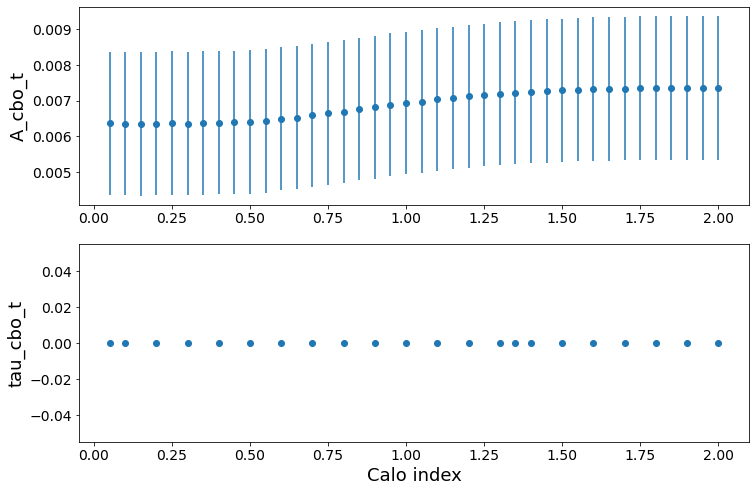

In [32]:
plt.figure(figsize=(12,8))
# fist line:
plt.subplot(211)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, A_cbo_t, yerr=dA_cbo_t, fmt="o")
plt.ylabel('A_cbo_t',fontsize=18)
#plt.ylim(-0.006,0.00)


# second line
plt.subplot(212)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.errorbar(calonum, tau_cbo_t, yerr=dtau_cbo_t, fmt="o")
plt.xlabel('Calo index',fontsize=18)
plt.ylabel('tau_cbo_t',fontsize=18)
#plt.ylim(0,2000)
plt.show()

In [33]:
r_avg=np.mean(rval)

In [34]:
dr_avg=np.mean(drval)

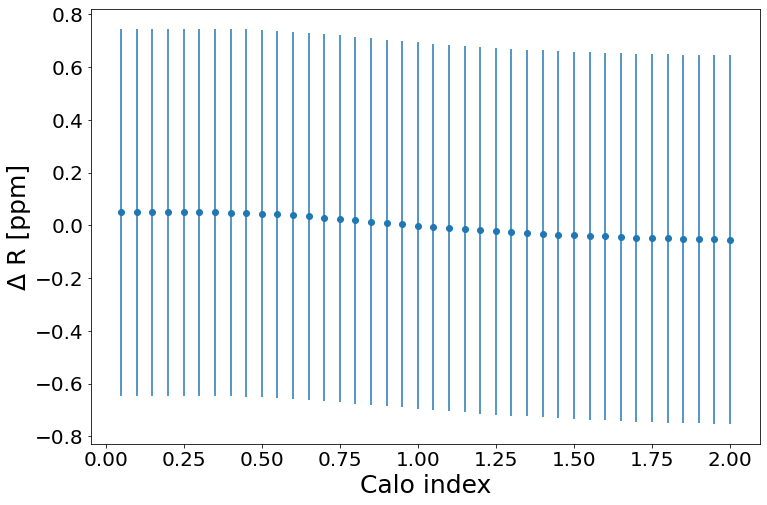

In [35]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.errorbar(calonum, rval-r_avg, yerr=np.sqrt((drval*drval)+(dr_avg*dr_avg)), fmt="o")
plt.xlabel('Calo index',fontsize=25)
plt.ylabel('Δ R [ppm]',fontsize=25)
plt.show()

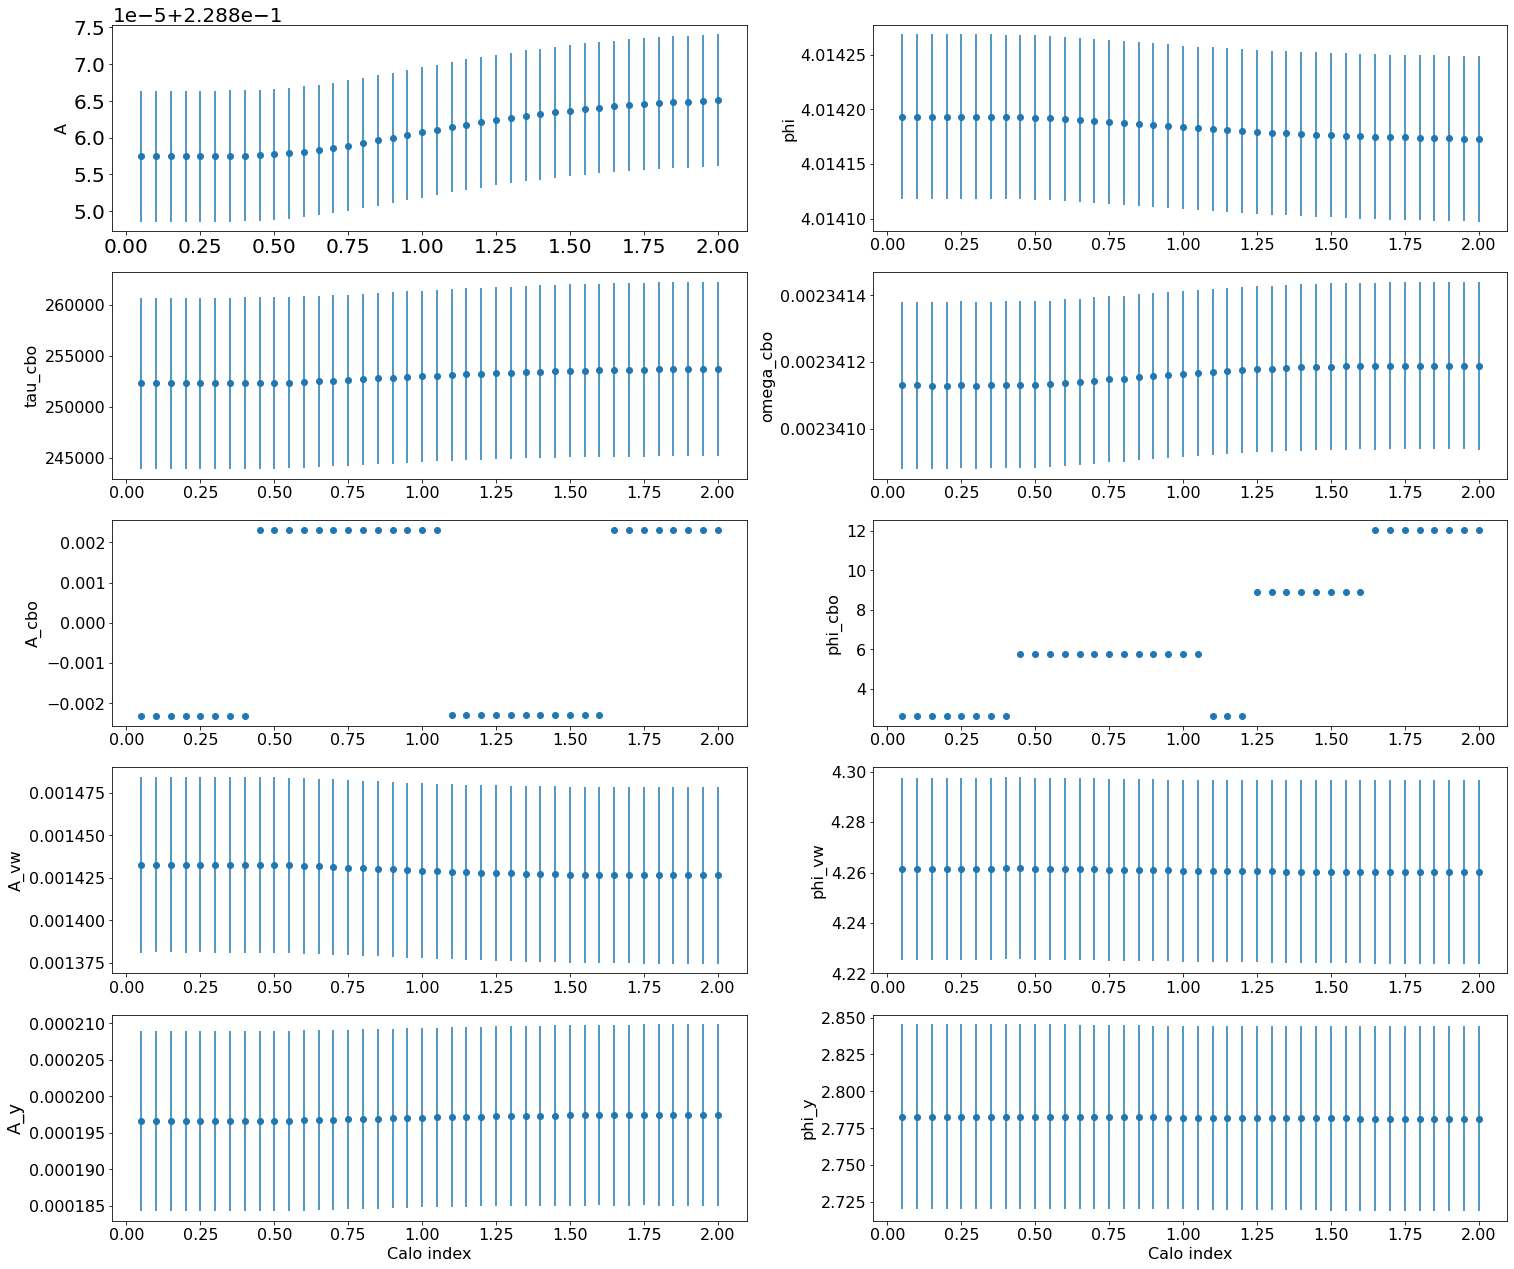

In [36]:
plt.figure(figsize=(25,22))

ax1 = plt.subplot2grid((5,2), (0,0))
# fist line:
#plt.subplot(521)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, asym, yerr=dasym, fmt="o")
plt.ylabel('A',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax2 = plt.subplot2grid((5,2), (0,1))
#plt.subplot(522)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, phi, yerr=dphi, fmt="o")
#plt.xlabel('Calo index',fontsize=22)
plt.ylabel('phi',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax3 = plt.subplot2grid((5,2), (1,0))
#plt.subplot(523)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, tau_cbo, yerr=dtau_cbo, fmt="o")
plt.ylabel('tau_cbo',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False
 
ax4 = plt.subplot2grid((5,2), (1,1))
#plt.subplot(524)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, omega_cbo, yerr=domega_cbo, fmt="o")
#plt.xlabel('Calo index',fontsize=18)
plt.ylabel('omega_cbo',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax5 = plt.subplot2grid((5,2), (2,0))
#plt.subplot(525)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, A_cbo, yerr=dA_cbo, fmt="o")
plt.ylabel('A_cbo',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax6 = plt.subplot2grid((5,2), (2,1))
#plt.subplot(526)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, phi_cbo, yerr=dphi_cbo, fmt="o")
#plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_cbo',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax7 = plt.subplot2grid((5,2), (3,0))
#plt.subplot(527)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, np.abs(A_vw), yerr=dA_vw, fmt="o")
plt.ylabel('A_vw',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax8 = plt.subplot2grid((5,2), (3,1))
#plt.subplot(528)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, phi_vw, yerr=dphi_vw, fmt="o")
#plt.xlabel('Calo index',fontsize=18)
plt.ylabel('phi_vw',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False

ax9 = plt.subplot2grid((5,2), (4,0))
#plt.subplot(529)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, np.abs(A_y), yerr=dA_y, fmt="o")
plt.xlabel('Calo index',fontsize=16)
plt.ylabel('A_y',fontsize=18)
plt.rcParams["axes.formatter.useoffset"] = False

ax10 = plt.subplot2grid((5,2), (4,1))
#plt.subplot(5210)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.errorbar(calonum, phi_y, yerr=dphi_y, fmt="o")
plt.xlabel('Calo index',fontsize=16)
plt.ylabel('phi_y',fontsize=16)
plt.rcParams["axes.formatter.useoffset"] = False
plt.show()